# SKLearn 

## Bike Sharing Demand 

По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов

В наборе признаков присутствуют вещественные, категориальные и бинарные данные

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются

## Библиотеки 

In [28]:
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd
import os

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных 

In [4]:
path = os.path.join('datasets', 'bike_sharing_demand.csv')
raw_data = pd.read_csv(path, header=0, sep=',')

In [6]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Предобработка данных 

#### Обучение и отложенный тест 

In [7]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [8]:
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)

In [9]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [10]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [11]:
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

In [12]:
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

In [15]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype=bool)

In [16]:
print(binary_data_columns)

['holiday', 'workingday']


In [17]:
print(binary_data_indices)

[False  True  True False False False False False False False]


In [18]:
categorical_data_columns = ['season', 'weather', 'month']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype=bool)

In [19]:
print(categorical_data_columns)

['season', 'weather', 'month']


In [20]:
print(categorical_data_indices)

[ True False False  True False False False False  True False]


In [23]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype=bool)

In [24]:
numeric_data_columns

['temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour']

In [25]:
numeric_data_indices

array([False, False, False, False,  True,  True,  True,  True,  True,
        True])

#### Pipeline

In [26]:
regressor = linear_model.SGDRegressor(random_state=0, n_iter=3, loss='squared_loss', penalty='l2')

In [39]:
estimator = pipeline.Pipeline(steps=[
    ('feature_preprocessing', pipeline.FeatureUnion(transformer_list = [
        ('binary_variables_preprocessing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])),
        ('numeric_vatiables_preprocessing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean=0.))
        ])),
        ('categorical_variables_preprocessing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
        ]))   
    ])),
    ('model_fitting', regressor)
    ]
)

In [40]:
estimator.fit(train_data, train_labels)

C:\Users\vlnlo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Pipeline(memory=None,
     steps=[('feature_preprocessing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_preprocessing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x0000029AD5E0D620>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
   ...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

In [41]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.82144006542809

#### Подбор параметров 

In [42]:
print(estimator.get_params().keys())

dict_keys(['memory', 'steps', 'feature_preprocessing', 'model_fitting', 'feature_preprocessing__n_jobs', 'feature_preprocessing__transformer_list', 'feature_preprocessing__transformer_weights', 'feature_preprocessing__binary_variables_preprocessing', 'feature_preprocessing__numeric_vatiables_preprocessing', 'feature_preprocessing__categorical_variables_preprocessing', 'feature_preprocessing__binary_variables_preprocessing__accept_sparse', 'feature_preprocessing__binary_variables_preprocessing__func', 'feature_preprocessing__binary_variables_preprocessing__inv_kw_args', 'feature_preprocessing__binary_variables_preprocessing__inverse_func', 'feature_preprocessing__binary_variables_preprocessing__kw_args', 'feature_preprocessing__binary_variables_preprocessing__pass_y', 'feature_preprocessing__binary_variables_preprocessing__validate', 'feature_preprocessing__numeric_vatiables_preprocessing__memory', 'feature_preprocessing__numeric_vatiables_preprocessing__steps', 'feature_preprocessing__

In [43]:
parameters_grid = {
    'model_fitting__alpha': [.0001, .001, .01],
    'model_fitting__eta0': [.001, 0.05]
}

In [44]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring='mean_absolute_error', cv=4)

In [45]:
%%time
grid_cv.fit(train_data, train_labels)

C:\Users\vlnlo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\vlnlo\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\vlnlo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\vlnlo\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\vlnlo\Anaconda3\lib\site-packages\sklea

Wall time: 547 ms


C:\Users\vlnlo\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\vlnlo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\vlnlo\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\vlnlo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\vlnlo\Anaconda3\lib\site-packages\sklea

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_preprocessing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_preprocessing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x0000029AD5E0D620>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
   ...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__alpha': [0.0001, 0.001, 0.01], 'model_fitting__eta0': [0.001, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [46]:
print(grid_cv.best_params_)

{'model_fitting__alpha': 0.01, 'model_fitting__eta0': 0.05}


In [47]:
print(grid_cv.best_score_)

-106.59260761001322


#### Оценка по отложенному тесту 

In [48]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [49]:
metrics.mean_absolute_error(test_labels, test_predictions)

129.27978020997608

In [50]:
print(test_labels[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [51]:
print(test_predictions[:20])

[144.64376856 172.30990187 218.22501306 252.63793875 269.70856583
 269.9495088  291.43509324 322.48223923 325.87836813 337.95337606
 335.79933706 326.73282524 308.14432385 289.18594975 276.12967877
 238.89077159 245.21254514  50.59988096  58.1332855   65.66669004]


(-100, 1100)

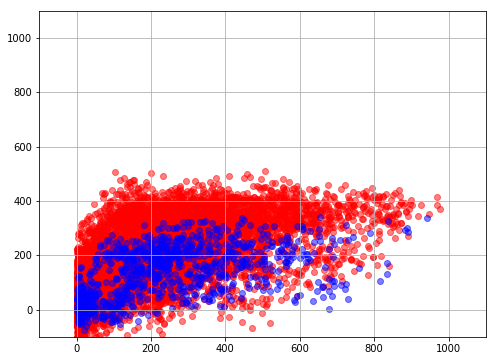

In [52]:
pylab.figure(figsize=(8, 6))
pylab.grid()
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
regressor = RandomForestRegressor(random_state=0, max_depth=20, n_estimators=50)

In [55]:
estimator = pipeline.Pipeline(steps=[
    ('feature_preprocessing', pipeline.FeatureUnion(transformer_list = [
        ('binary_variables_preprocessing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])),
        ('numeric_vatiables_preprocessing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean=0.))
        ])),
        ('categorical_variables_preprocessing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
        ]))   
    ])),
    ('model_fitting', regressor)
    ]
)

In [56]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_preprocessing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_preprocessing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x0000029AD6227AE8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
   ..._estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [57]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.70102812235277

In [60]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [61]:
estimator.predict(test_data)[:10]

array([399.484     , 498.94      , 259.89095238, 168.22974183,
       207.34808887, 269.85813168, 274.43748506, 329.90594729,
       289.75397589, 447.23      ])

(-100, 1100)

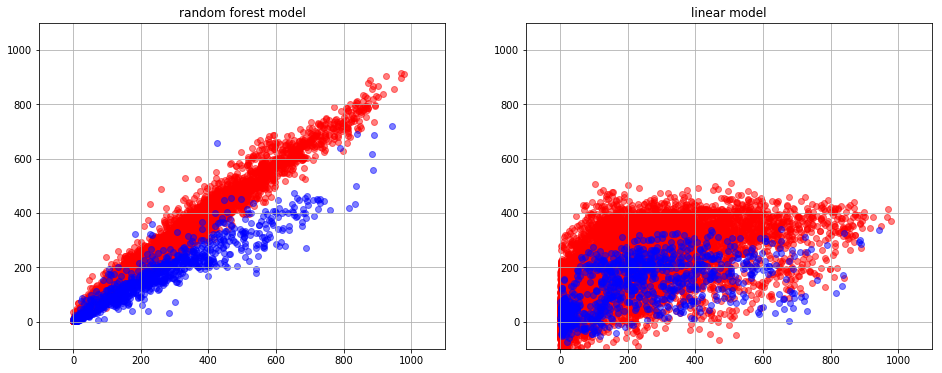

In [62]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1, 2, 1)
pylab.grid()
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color='blue')
pylab.title('random forest model')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)

pylab.subplot(1, 2, 2)
pylab.grid()
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')
pylab.title('linear model')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)